#### Import all needed libraries - keras for retrieving CNN codes using pretrained imageNet model, scikit for dimensionality reduction and building a classifier using random forest.

In [1]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
import numpy as np
from vgg19 import VGG19
from keras.preprocessing import image
from imagenet_utils import preprocess_input
from keras.models import Model
import os
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2 
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

Using Theano backend.


#### get back the convolutional part of a VGG network trained on ImageNet and define UDF to get CNN codes for input image

In [5]:
model_vgg16_conv = VGG16(weights='imagenet', include_top=False)

<img src="cnn_demo.jpg">

In [7]:
def CNNcodes(folder,filename):
    path = folder + filename;
    img_path = path
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    z=model_vgg16_conv.predict(x)
    return(z.flatten())

#### Lets look at some sample images from both classes ie. News vs. NonNews.

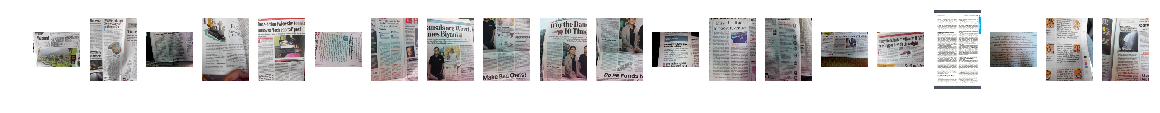

In [59]:
#News
#News Image training data
plt.figure(figsize=(20,120))
fl = [i for i in os.listdir("data/News")];
for i in range(0,20):
    plt.axis('off')
    plt.subplot(1,20,i+1)
    img = Image.open("data/News/"+fl[i+20])
    img.thumbnail((224, 224)) # resizes image in-place
    imgplot = plt.imshow(img)
    plt.axis('off')

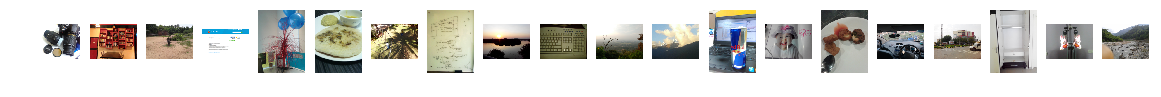

In [61]:
#NonNews
#NonNews Image training data
plt.figure(figsize=(20,120))
fl = [i for i in os.listdir("data/NonNews")];
for i in range(0,20):
    plt.axis('off')
    plt.subplot(1,20,i+1)
    img = Image.open("data/NonNews/"+fl[i+25])
    img.thumbnail((224, 224)) # resizes image in-place
    imgplot = plt.imshow(img)
    plt.axis('off')

#### Lets generate input features and labels from training dataset. We are doing a binary classification- news vs. non-news. > folder : data/News and data/NonNews

In [8]:
#for news images
a = [i for i in os.listdir("data/News")];
fn = ["News"+i.replace(" ","_") for i in a];
label = 'News';
news_data = []
for iter in range(0,len(a)-1):
    res = CNNcodes("data/News/",a[iter]);
    news_data.append(res);
                  
#for non-news
a = [i for i in os.listdir("data/NonNews")];
fn = ["NonNews"+i.replace(" ","_") for i in a];
label = 'NonNews';
nonnews_data = []
for iter in range(0,len(a)):
    res = CNNcodes("data/NonNews/",a[iter]);
    nonnews_data.append(res);

#union news and nonnews and define labels    
X=np.concatenate((news_data,nonnews_data),axis=0)
y1=['News' for i in range(0,49)]    
y2=['NonNews' for i in range(0,59)]  
Y=np.concatenate((y1,y2),axis=0)       

In [14]:
X.shape

(108, 25088)

In [15]:
Y.shape

(108,)

#### Next, (i) Do dimensionality reduction using scikit topK features (ii) Run a random forest classifier on reduced dataset 

In [62]:
X_new = SelectKBest(chi2, k=100).fit_transform(X, Y); 
pcamodel=SelectKBest(chi2, k=100).fit(X, Y); 
rf = RandomForestClassifier(n_estimators=10, n_jobs=2)
rf.fit(X_new, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

#### Lets predict using model

In [63]:
def test(folder,fn):
    code = CNNcodes(folder,fn);
    code1 = pcamodel.transform(code);
    return(rf.predict(code1)[0])  ;          

In [65]:
print test("Pictures/","test18.jpg");  

News


/home/deepak/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


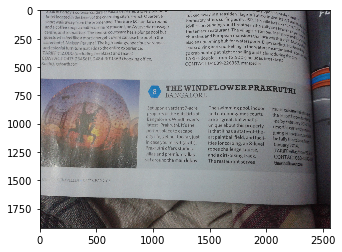

In [66]:
img=mpimg.imread('Pictures/test18.jpg')
imgplot = plt.imshow(img)

### Summary & Metrics (on validation set)    >>>>>>>>   On running the predict method on 1,219 images on my mobile. The model identified 72 as news images and 1,147 as non-news images. Precision on news image turned out to be - 91% with a 100% recall. This is pretty impressive to see such accuracies with little or no effort. some handwritten whiteboard image were classifed as "news" leading to a drop in precision.